In [93]:
%load_ext autoreload
%autoreload 2
from config import settings
import torch
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_1104531/1669040281.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

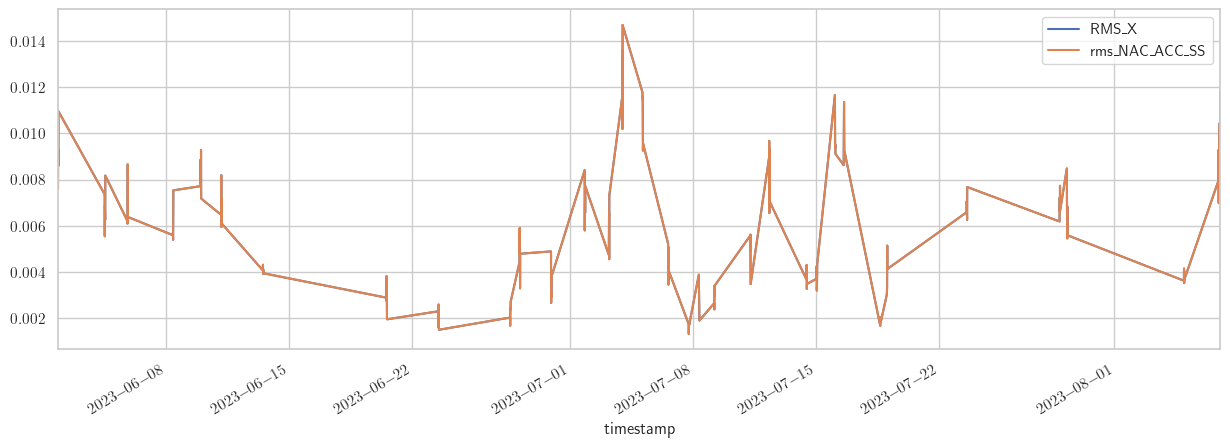

In [94]:

db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


In [95]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)

Query: SELECT Welch_X, Welch_Y, Welch_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z FROM processed_data WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01'


                Statistics Table                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │      4.191697 │
│ Welch_X          │ min       │    -18.741716 │
│ Welch_X          │ std       │    -0.9837241 │
│ Welch_X          │ mean      │    -3.8683734 │
│ Welch_Y          │ max       │      4.869997 │
│ Welch_Y          │ min       │    -19.199324 │
│ Welch_Y          │ std       │    -1.4130867 │
│ Welch_Y          │ mean      │     -3.827928 │
│ Welch_Z          │ max       │   -0.17400934 │
│ Welch_Z          │ min       │    -18.453154 │
│ Welch_Z          │ std       │     -5.803719 │
│ Welch_Z          │ mean      │    -7.3886003 │
│ RollingAverage_X │ max       │   0.076331586 │
│ RollingAverage_X │ min       │   -0.07509273 │
│ RollingAverage_X │ std       │   0.006984314 │
│ RollingAverage_X │ mean      │ 6.8863737e-09 │
│ RollingAverage_Y │ max       │    0.09320284 │
│ RollingAverage_Y │ min       │   -0.09582217 │
│ RollingAverage_Y │ std       │  0.0063185487 │
│ RollingAverage_Y │ mean      │  9.452088e-09 │
│ RollingAverage_Z │ max       │    0.01842118 │
│ RollingAverage_Z │ min       │  -0.012660166 │
│ RollingAverage_Z │ std       │ 0.00070675137 │
│ RollingAverage_Z │ mean      │  8.574571e-10 │
└──────────────────┴───────────┴───────────────┘

In [96]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,['DEM5_TP_SG_LAT014_Mtn','mean_windspeed'],
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)

Query: SELECT DEM5_TP_SG_LAT014_Mtn, mean_windspeed FROM scada WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01'


                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
│ mean_windspeed        │ max       │      23.4941 │
│ mean_windspeed        │ min       │       0.4712 │
│ mean_windspeed        │ std       │       4.2531 │
│ mean_windspeed        │ mean      │       9.0622 │
└───────────────────────┴───────────┴──────────────┘

In [97]:
statistics_scada['DEM']= statistics_scada['DEM5_TP_SG_LAT014_Mtn']
statistics.update(statistics_scada)

In [98]:
from src.model.prepared_queries import simple_view, do_nothing
from src.model.transformation import EncoderBasedOnList
columns = ["Welch_X", "Welch_Y", "Welch_Z",'turbine_name']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]*3+[EncoderBasedOnList(settings.norther.turbine_list.to_list())]
freq_axis_masked = transform_func[0][1].freq_axis_masked
transform_func[0]
key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=64,
    cached=True,
    return_dict=True
)


In [99]:
from src.model.backbone.VAE import TrainingMultiHeadVAE
from src.model.backbone.VQ_VAE import TrainingMultiHeadVQVAE
from src.model.backbone.aligner import TrainingMultiHeadAEAligned
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
torch.set_float32_matmul_precision("high")
# Initialize the model
vae_model = TrainingMultiHeadAEAligned(
    input_spec={'Welch_X': 492, 'Welch_Y': 492, 'Welch_Z': 492},
    latent_dim=32,
    separated_layer=[128],
    shared_layer=[128],
    activation_str='relu',
    batch_norm=False,
    normalization_values=statistics,
    lr_ae=5e-3,

)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="train_recon_loss",
    dirpath="checkpoints/",
    filename="vae-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)

early_stopping_callback = EarlyStopping(
    monitor="train_recon_loss",
    patience=20,
    mode="min"
)

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=150,
    accelerator='gpu',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
)

# Train the model
trainer.fit(vae_model, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name               | Type                              | Params | Mode 
---------------------------------------------------------------------------------
0 | model              | MultiHeadAutoEncoderAndClassifier | 491 K  | train
1 | recon_loss_fn      | MSELoss                           | 0      | train
2 | class_loss_fn      | C

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Not run the following

In [100]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all, welch_all_scada_wo_dem
columns = ['Welch_X','Welch_Y','Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name','timestamp']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ 3*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM processed_scada"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='processed_scada',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)

In [101]:


data_loader_dem.setup() 
dfs = []
for batch in data_loader_dem.all_dataloader():
    vae_model.eval()
    #b['Welch'] = b['Welch_X']
    batch = {k: v.to(vae_model.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

    with torch.no_grad():
        enc = vae_model.model(batch)
    mu = enc['latent']
    
    df_temp = pd.DataFrame({'mean_windspeed':batch['mean_windspeed'].cpu().numpy(),
                            'mean_power':batch['mean_power'].cpu().numpy(),
                            'mean_pitch':batch['mean_pitch'].cpu().numpy(),
                            'mean_rpm':batch['mean_rpm'].cpu().numpy(),
                            'caseID':batch['caseID'],
                            'embedding':[e.cpu().numpy() for e in mu],
                            'turbine_name':batch['turbine_name'],
                            'timestamp':batch['timestamp']})
    dfs.append(df_temp)
df = pd.concat(dfs)
df['caseID']=df['caseID'].apply(lambda x: x.split(':')[0])
definitions = settings.case_definitions.to_list()
caseid_to_parent_first = {definition['name']: definition['parent_class'][0] for definition in definitions}
caseid_to_parent_first['Missing SCADA'] = "Missing SCADA"
df['ParentCase'] = df['caseID'].map(caseid_to_parent_first)
df['turbine_name'].unique()

array(['NRTA01', 'NRTA02', 'NRTA03', 'NRTA04', 'NRTB01', 'NRTB02',
       'NRTB03', 'NRTB04', 'NRTC01', 'NRTC02', 'NRTC03', 'NRTC04',
       'NRTD01', 'NRTD02', 'NRTD03', 'NRTD04', 'NRTE01', 'NRTE02',
       'NRTE03', 'NRTE04', 'NRTF01', 'NRTF02', 'NRTF03', 'NRTF04',
       'NRTG01', 'NRTG02', 'NRTG03', 'NRTG04', 'NRTH01', 'NRTH02',
       'NRTH03', 'NRTH04', 'NRTI01', 'NRTI02', 'NRTI03', 'NRTI04',
       'NRTJ01', 'NRTJ02', 'NRTJ03', 'NRTJ04', 'NRTK01', 'NRTK02',
       'NRTK03', 'NRTK04'], dtype=object)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import umap
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
sns.set(style="whitegrid")

embeddings = np.vstack(df['embedding'].values)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# turn the embeddings into a dataframe where each row and column is a list of the embeddings 
df_embendings = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, df_embendings], axis=1)

from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
df_turb = df
norm1 = Normalize(vmin=df_turb.mean_power.min(), vmax=df_turb.mean_power.max())
sc1 = ax[0, 0].scatter(
    df_turb['x'], df_turb['y'], 
    c=norm1(df_turb['mean_power']), 
    cmap="viridis", 
    s=10, alpha=.3
)
ax[0, 0].set_title('Mean Power',fontsize=20)
#
#ax[0,0].set_ylim([0,8])
sm1 = cm.ScalarMappable(cmap='viridis', norm=norm1)
sm1.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm1, ax=ax[0, 0])
cbar.ax.set_ylabel(ylabel='Mean Power', fontsize=17)
cbar.set_ticks([df_turb.mean_power.min(), df_turb.mean_power.max()/2, df_turb.mean_power.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

# Mean Pitch
norm3 = Normalize(vmin=df_turb.mean_pitch.min(), vmax=df_turb.mean_pitch.max())
sc3 = ax[0, 1].scatter(
    df_turb['x'], df_turb['y'],
    c=norm3(df_turb.mean_pitch), cmap='viridis', s=10, alpha=.3
)
ax[0, 1].set_title('Mean Pitch',fontsize=20)
#ax[0,1].set_ylim([0,8])
sm2 = cm.ScalarMappable(cmap='viridis', norm=norm3)
sm2.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm2, ax=ax[0, 1], label='Mean Pitch')
cbar.ax.set_ylabel(ylabel='Mean Pitch', fontsize=17)
cbar.set_ticks([df_turb.mean_pitch.min(), df_turb.mean_pitch.max()/2, df_turb.mean_pitch.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

# Mean RPM
norm4 = Normalize(vmin=df_turb.mean_rpm.min(), vmax=df_turb.mean_rpm.max())
sc4 = ax[1, 0].scatter(
    df_turb.x, df_turb.y,
    c=norm4(df_turb.mean_rpm), cmap='viridis', s=10, alpha=.3
)
ax[1, 0].set_title('Mean RPM',fontsize=20)
#ax[1,0].set_ylim([0,8])
sm4 = cm.ScalarMappable(cmap='viridis', norm=norm4)
sm4.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm4, ax=ax[1, 0])
cbar.ax.set_ylabel(ylabel='Mean RPM', fontsize=17)
cbar.set_ticks([df_turb.mean_rpm.min(), df_turb.mean_rpm.max()/2, df_turb.mean_rpm.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

import matplotlib.colors as mcolors

# Define custom palette and mapping
custom_palette = {
    "Missing SCADA": "grey",
    "Operational": "tab:blue",
    "Transition": "darkred",
    "Derated": "darkorange",
    "Standstill": "purple",
}

# Map ParentCase to integers for colormap
parentcase_mapping = {key: i for i, key in enumerate(custom_palette.keys())}
df_turb['ParentCaseNum'] = df_turb['ParentCase'].map(parentcase_mapping)

# Create a colormap with the same order as custom_palette
cmap = mcolors.ListedColormap(custom_palette.values())

# Scatter plot with numerical mapping
sc5 = ax[1, 1].scatter(
    df_turb['x'], df_turb['y'], 
    c=df_turb['ParentCaseNum'], 
    cmap=cmap, 
    s=10, alpha=0.3
)

# Create a ScalarMappable for the colorbar without alpha
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(custom_palette) - 1))
sm.set_array([])  # Required for ScalarMappable

# Add the colorbar without alpha
cbar = fig.colorbar(sm, ax=ax[1, 1])
cbar.set_ticks(list(parentcase_mapping.values()))
cbar.set_ticklabels(list(custom_palette.keys()))
cbar.ax.tick_params(labelsize=13)

ax[1, 1].set_title('Operational Regime',fontsize=20)
#ax[1,1].set_ylim([0,8])

df_transition = df_turb[df_turb['ParentCase'] == 'Transition']
ax[1,1].scatter(data=df_transition,
    x='x',
    y='y',
    color='darkred',
    s=7,
    label='Transition'
)
# plot derated points with a different marker 
df_derated = df_turb[df_turb['ParentCase'] == 'Derated']
ax[1,1].scatter(data=df_derated,
    x='x',
    y='y',
    color='darkorange',
    s=7,
    label='Derated'
)

for i in range(4):
    # remove the x and y axis labels and ticks 
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])

#cbar.ax.set_yticklabels([label_mapping[i] for i in range(len(label_mapping))])


# Adjust layout and show plot
plt.tight_layout()
plt.savefig('embedding_plot.png', dpi=300)
plt.show()


/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all, welch_all_scada_wo_dem
columns = ['Welch_X','Welch_Y','Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name','timestamp','DEM']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ 4*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)
data_loader_dem.setup() 

In [ ]:
dfs = []
for batch in data_loader_dem.train_dataloader():
    batch = {k: v.to(vae_model.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    with torch.no_grad():
        data = vae_model.model(batch)
    df_temp = pd.DataFrame({'embedding' : [e for e in data['latent'].cpu().numpy()],
                            'turbine_name': batch['turbine_name'],
                            'timestamp': batch['timestamp'],
                            'DEM': batch['DEM'].cpu().numpy(),
                           'caseID': batch['caseID']})
    dfs.append(df_temp)


In [ ]:
df_emb_dem = pd.concat(dfs)

In [ ]:
df_emb_dem['caseID']=df_emb_dem['caseID'].apply(lambda x: x.split(':')[0])
definitions = settings.case_definitions.to_list()
caseid_to_parent_first = {definition['name']: definition['parent_class'][0] for definition in definitions}
caseid_to_parent_first['Missing SCADA'] = "Missing SCADA"
df_emb_dem['ParentCase'] = df_emb_dem['caseID'].map(caseid_to_parent_first)
df_emb_dem['turbine_name'].unique()

array(['NRTJ03', 'NRTH01', 'NRTC01', 'NRTC03', 'NRTF03'], dtype=object)

In [ ]:
df_emb_dem['turbine_name_enc'] = EncoderBasedOnList(settings.norther.turbine_list)(df_emb_dem['turbine_name'].values)

In [ ]:
# run DBSCAN on the embeddings to find the clusters
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=200, min_samples=10, cluster_selection_epsilon=1)
df_emb_dem['cluster'] = clusterer.fit_predict(df_emb_dem['embedding'].values.tolist())
df_emb_dem['cluster'].value_counts()

cluster
 0    10083
 1      577
-1      424
Name: count, dtype: int64

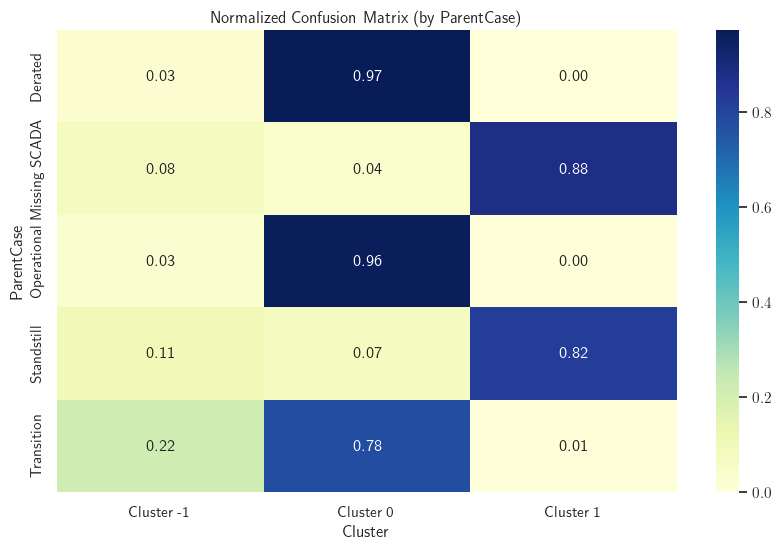

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the cluster labels are set as strings (if not already)
df_emb_dem['cluster_n'] = df_emb_dem['cluster'].apply(lambda x: f'Cluster {x}')

# Create the contingency table (confusion matrix)
contingency_table = pd.crosstab(df_emb_dem['ParentCase'], df_emb_dem['cluster_n'])


# Normalize the confusion matrix by parent case (i.e., row-wise normalization)
normalized_confusion = contingency_table.div(contingency_table.sum(axis=1), axis=0)


# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_confusion, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Confusion Matrix (by ParentCase)")
plt.xlabel("Cluster")
plt.ylabel("ParentCase")
plt.show()


In [ ]:
# train a random forest on the embedding to predict the DEM using only the 2 first turbines
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


df_emb_dem_train = df_emb_dem.query(f'turbine_name in {fleet_leaders[:2]}')
X = np.stack(df_emb_dem_train['embedding'].values)
y = df_emb_dem_train['DEM'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)


114801637115.68248

In [ ]:
df_emb_dem['pred_dem'] = rf.predict(np.stack(df_emb_dem['embedding'].values))

In [ ]:
df_emb_dem['timestamp']= pd.to_datetime(df_emb_dem['timestamp'])
df_emb_dem.sort_values('timestamp', inplace=True)

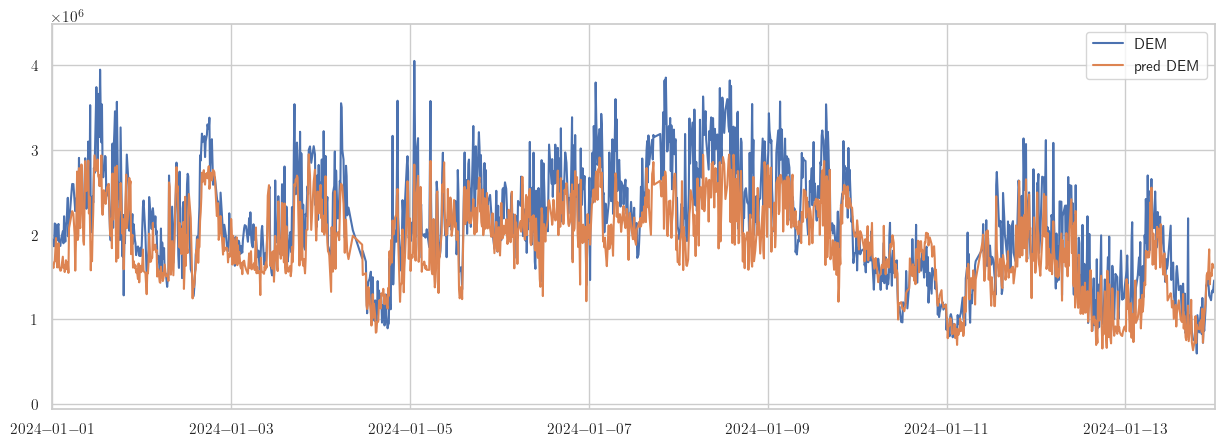

In [ ]:
df_emb_dem_turb = df_emb_dem[df_emb_dem['turbine_name']=='NRTH01']
fig,ax= plt.subplots(1,1,figsize=(15,5))
start_time = pd.to_datetime('2024-01-01')
end_time = pd.to_datetime('2024-01-14')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['DEM'], label='DEM')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['pred_dem'], label='pred DEM')
ax.set_xlim(start_time, end_time)
ax.legend()
plt.show()

In [ ]:
from src.evaluation.metric import r2_score, relative_err

df_emb_dem.groupby('turbine_name').apply(lambda x: relative_err(x['DEM'], x['pred_dem']))

/tmp/ipykernel_1104531/1487434706.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_emb_dem.groupby('turbine_name').apply(lambda x: relative_err(x['DEM'], x['pred_dem']))


turbine_name
NRTC01    0.071809
NRTC03    0.065922
NRTF03    0.182089
NRTH01    0.169537
NRTJ03    0.187777
dtype: float64